# Complex example

The goal of this notebook is to combine everything that i learned from previous experiments and make a more generic and reliable process that is closer to the actual 'final' program that will hanlde pictures of tangible programs.

## Init

In [17]:
# TODO: check imports
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv
import pytesseract
import os
from PIL import Image
from scipy.ndimage import label
from scipy.ndimage import binary_closing
from anytree import Node, RenderTree

# First block id + 1
BLOCK_ID = 0 

# List that holds block objects
block_list = []

A = np.array(Image.open('test_images/complex_example_image.PNG'))
A = cv.resize(A, dsize=(1500, 1200), interpolation=cv.INTER_CUBIC)

class code_block:
    def __init__(self, b_id, text, x, y, w, h):
        self.b_id = b_id
        self.text = text
        self.x = x
        self.y = y
        self.width = w
        self. height = h

    def __str__(self):
        return '{self.b_id}, "{self.text}" at ({self.x}, {self.y})'.format(self = self)

def new_block(text, x, y, w, h):
    global BLOCK_ID 
    BLOCK_ID += 1
    block_list.append(code_block(BLOCK_ID, text, x, y, w, h))
    return block_list[BLOCK_ID - 1]

# Seperate Components

In order to seperate and label each block from the image i convert it to the HSV colorspace and apply the connected component method on the thresholded saturation chanel. This will work for most pictures of tangilble programs on a white background as colorful block will always be more saturated that the background. 

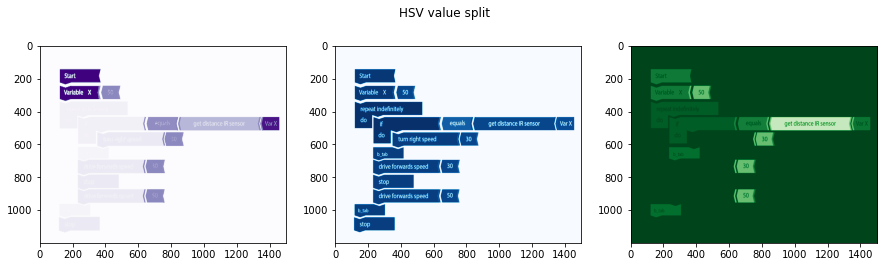

In [18]:
# Original image to HSV
hsv_A = cv.cvtColor(A, cv.COLOR_RGB2HSV)

# Split each chanel...
h,s,v = cv.split(hsv_A)

# ...and display it.
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('HSV value split')
ax1.imshow(h, cmap='Purples')
ax2.imshow(s, cmap='Blues')
ax3.imshow(v, cmap='Greens')
fig.show() 

## Mask generation - Preparing features for Tesseract OCR

Found 18 blocks in image
 +++ ++ +++
Block's id: 1 at (120, 141)
Tesseract read: Start



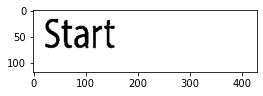

Block's id: 2 at (120, 242)
Tesseract read: Variable X



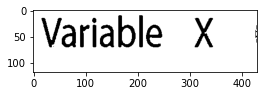

Block's id: 3 at (372, 242)
Tesseract read: 50



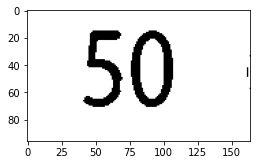

Block's id: 4 at (120, 340)
Tesseract read: repeat indefinitely



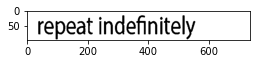

Block's id: 5 at (233, 433)
Tesseract read: if



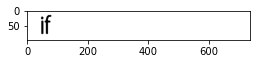

Block's id: 6 at (648, 433)
Tesseract read: equals



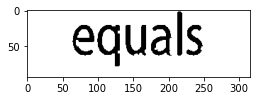

Block's id: 7 at (839, 433)
Tesseract read: get distance IR sensor



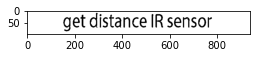

Block's id: 8 at (1338, 433)
Tesseract read: Var X



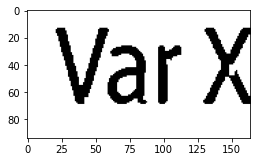

Block's id: 9 at (349, 526)
Tesseract read: turn right speed



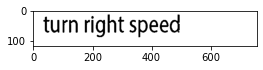

Block's id: 10 at (757, 526)
Tesseract read: 30



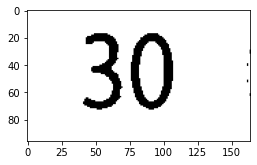

Block's id: 11 at (232, 617)
Tesseract read: b_ tab



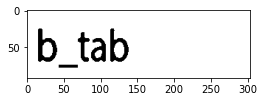

Block's id: 12 at (231, 693)
Tesseract read: drive forwards speed



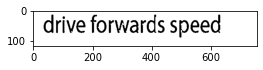

Block's id: 13 at (642, 693)
Tesseract read: 30



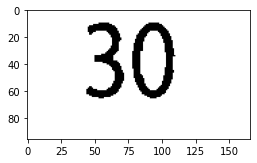

Block's id: 14 at (231, 784)
Tesseract read: stop



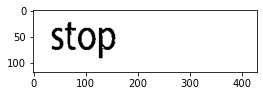

Block's id: 15 at (231, 873)
Tesseract read: drive forwards speed



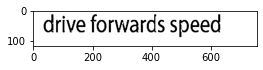

Block's id: 16 at (642, 873)
Tesseract read: 50



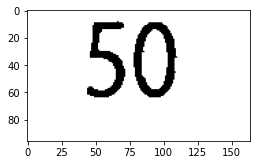

Block's id: 17 at (119, 963)
Tesseract read: b_tab



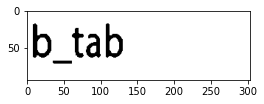

Block's id: 18 at (116, 1043)
Tesseract read: stop



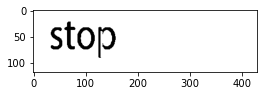

In [19]:
# Original image to grayscale
gray_A = cv.cvtColor(A, cv.COLOR_BGR2GRAY)

# Kernel that will be used in later morphological trasformations
closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))

# threshold saturation chanel
ret3, th_saturation = cv.threshold(s, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

# dilating thresholded image to remove letters
kernel = cv.getStructuringElement(cv.MORPH_RECT, (2,2))
th_saturation = cv.dilate(th_saturation, kernel, iterations = 3)

# using connected components (CC) method to label each block
num_labels, labels_im = cv.connectedComponents(th_saturation)

print('Found {} blocks in image\n +++ ++ +++'.format(num_labels-1))
for num in range(1, num_labels):

    # Extracting mask from (CC) result
    label = labels_im == num
    block_mask = np.copy(th_saturation)
    block_mask[label == False] = 0
    block_mask[label == True] = 255

###############################################################################
    # find coordinates (x, y) and hight - width of the block (h, w) based on 
    # the blocks mask
    contours, _ = cv.findContours(block_mask, cv.RETR_TREE, \
        cv.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv.boundingRect(contours[0])

    # masking to extract image feature from image
    feature = cv.bitwise_and(gray_A, gray_A, mask=block_mask)

    # Cropping each block to help with binarization later
    # Using a temporary cropping solution to crop control blocks 
    # TODO: find a better way to crop all blocks 
    # (maybe use image_to_data() from Tesseract)
    crop_v = 18
    if h > 150:
        feature = feature[y+crop_v:y+h-crop_v-80, x+crop_v: x+w-crop_v-10]
    else:
        feature = feature[y+crop_v:y+h-crop_v, x+crop_v: x+w-crop_v]
    
    # upscale feature image
    multiplier = 2
    feature = cv.resize(feature, dsize=(feature.shape[1]*multiplier, \
        feature.shape[0]*multiplier), interpolation=cv.INTER_CUBIC)

    # binarize and invert feature
    ret3, th_feature = cv.threshold(feature, 0, 255, \
        cv.THRESH_BINARY+cv.THRESH_OTSU)
    closing = cv.morphologyEx(th_feature, cv.MORPH_CLOSE, closing_kernel)
    inv_feature = np.invert(closing)
    
    # Tesseract 
    config = '--psm 7'
    text_in_block = pytesseract.image_to_string(inv_feature,\
         lang='eng', config=config)

    # save block information
    nb = new_block( ' '.join(text_in_block.split()), x, y, w, h)
    
    # Print pre-process/ Tesseract results
    print('Block\'s id: {} at ({}, {})\nTesseract read: {}'.format(nb.b_id, \
        nb.x, nb.y, text_in_block))
    plt.figure(figsize=(4,8))
    plt.imshow(inv_feature, cmap='gray')
    plt.show()

# Syntax Tree using anytree lib

In order to generate blockly XML correctly an Abstract Syntax Tree (AST) needs to be generated. Using the following functions the program checks for attached, idented or blocks underneath each block making connections between them.


In [20]:
# get_underneath: returns the block underneath my_block if there is one
# else None.
def get_underneath(my_block):
    thr = 30
    res_block =  None
    for block in block_list:
        # Skip the same block as my_block in the block_list or blocks that are 
        # higher in the picture than my_block.
        if block.b_id == my_block.b_id or block.y < my_block.y: 
            # print('Skipped {}'.format(block.text))
            continue
        # Searching for a block that: 
        # * is `not` more to the right or left than my block in the x axis 
        #   + threshold
        # * is `not` lower that my_block's height + threshold
        if  my_block.x - thr < block.x < my_block.x + thr and \
            block.y < my_block.y + my_block.height + thr:
            res_block = block
    return res_block 

# Test if it works
for block in block_list:
    res = get_underneath(block)
    print('{:2}: {:<25} has {} underneath'.format(block.b_id, block.text, res))


1: Start                     has 2, "Variable X" at (120, 242) underneath
 2: Variable X                has 4, "repeat indefinitely" at (120, 340) underneath
 3: 50                        has None underneath
 4: repeat indefinitely       has None underneath
 5: if                        has 11, "b_ tab" at (232, 617) underneath
 6: equals                    has None underneath
 7: get distance IR sensor    has None underneath
 8: Var X                     has None underneath
 9: turn right speed          has None underneath
10: 30                        has None underneath
11: b_ tab                    has 12, "drive forwards speed" at (231, 693) underneath
12: drive forwards speed      has 14, "stop" at (231, 784) underneath
13: 30                        has None underneath
14: stop                      has 15, "drive forwards speed" at (231, 873) underneath
15: drive forwards speed      has None underneath
16: 50                        has None underneath
17: b_tab                   

In [21]:
# get_attached_to: returns the attached block to my_block if there is one
# else None.
def get_attached_to(my_block):
    thr = 30
    res_block = None
    for block in block_list:
        # Skip the same block as my_block in the block_list or blocks that are 
        # more to the left of the picture than my_block.
        if block.b_id == my_block.b_id or block.x < my_block.x:      
            # print('Skipped {}'.format(block.text))
            continue 
        # Searching for a block that: 
        # * is `not` higher or lower than my block in the y axis + threshold
        # * is `not` more to the right that my_block's width + threshold
        if  my_block.y - thr < block.y < my_block.y + thr and \
            block.x < my_block.x + my_block.width + thr :
            res_block = block
    return res_block 

# Test if it works
for block in block_list:
    res = get_attached_to(block)
    print('{:2}: {:<25} has {} attached'.format(block.b_id, block.text, res))

1: Start                     has None attached
 2: Variable X                has 3, "50" at (372, 242) attached
 3: 50                        has None attached
 4: repeat indefinitely       has None attached
 5: if                        has 6, "equals" at (648, 433) attached
 6: equals                    has 7, "get distance IR sensor" at (839, 433) attached
 7: get distance IR sensor    has 8, "Var X" at (1338, 433) attached
 8: Var X                     has None attached
 9: turn right speed          has 10, "30" at (757, 526) attached
10: 30                        has None attached
11: b_ tab                    has None attached
12: drive forwards speed      has 13, "30" at (642, 693) attached
13: 30                        has None attached
14: stop                      has None attached
15: drive forwards speed      has 16, "50" at (642, 873) attached
16: 50                        has None attached
17: b_tab                     has None attached
18: stop                      has N

In [22]:
# get_idented_to: returns the idented block to my_block if there is one
# else None.
def get_idented_to(my_block):
    res_block =  None
    thr = 10
    for block in block_list:
        # Skip the same block as my_block in the block_list or blocks that are 
        # higher than my_block.
        if block.b_id == my_block.b_id or block.y < my_block.y: 
            #print('Skipped {}'.format(block.text))
            continue
        # Searching for a block that: 
        # * is within the range of my_block's width + threshold
        # * is below my_block
        if  my_block.x < block.x < my_block.x + my_block.width and \
            block.y < my_block.y + my_block.height + thr:
            res_block = block

    return res_block

# Test if it works
for block in block_list:
    res = get_idented_to(block)
    print('{:2}: {:<25} has {} idented'.format(block.b_id, block.text, res))

1: Start                     has None idented
 2: Variable X                has None idented
 3: 50                        has None idented
 4: repeat indefinitely       has 5, "if" at (233, 433) idented
 5: if                        has 9, "turn right speed" at (349, 526) idented
 6: equals                    has 7, "get distance IR sensor" at (839, 433) idented
 7: get distance IR sensor    has 8, "Var X" at (1338, 433) idented
 8: Var X                     has None idented
 9: turn right speed          has 10, "30" at (757, 526) idented
10: 30                        has None idented
11: b_ tab                    has None idented
12: drive forwards speed      has 13, "30" at (642, 693) idented
13: 30                        has None idented
14: stop                      has None idented
15: drive forwards speed      has 16, "50" at (642, 873) idented
16: 50                        has None idented
17: b_tab                     has None idented
18: stop                      has None ide

## Main logic for generating AST and result

In [23]:
from difflib import SequenceMatcher

# similar(): 
# returns: a precentage of string a, b similarity
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Root of the AST
root = Node('tangible program')

next_block = None
nesting_level = root    # current identation level
start = Node(block_list[0].text, parent=nesting_level) # init first node
previous_node = start
nesting_levels = []     # save all nesting levels so i can go back
nesting_levels.append(nesting_level)
index = 0               # index of nesting_level list

# Asuming all blocks in the list are sorted
for i in range(1, len(block_list)):
    # print('{}: {}'.format(i, block_list[i]))

    ## "Special blocks" ##
    if similar(block_list[i].text, 'b_tab') > 0.8: # TODO: This can be done without relying on this blocks text
        # print('{} is {} similar to b_tab'.format(block_list[i].text, similar(block_list[i].text, 'b_tab')))
        if index != 0:
            index -= 1
        continue

    if similar(block_list[i].text, 'repeat indefinitely do') > 0.7: # TODO: or any other control block
        new_node = Node(block_list[i].text, parent=nesting_levels[index])
        previous_node = new_node
        nesting_level = new_node
        nesting_levels.append(nesting_level)
        index += 1
        continue
    ##  #  #  #  #  #  ##

    res = get_attached_to(block_list[i-1])
    if res != None and res.b_id == block_list[i].b_id:
        # the block is to the right of the previous block
        # attach node to previous Node
        new_node = Node(res.text, parent=previous_node)
        previous_node = new_node
        continue

    res = get_idented_to(block_list[i-1])
    if res != None and res.b_id == block_list[i].b_id:
        # print('{} is idented to {}'.format(res.text,block_list[i-1].text))
        # the block is idented to the previous block
        new_node = Node(res.text, parent=previous_node)
        nesting_level = new_node
        nesting_levels.append(nesting_level)
        index += 1
        previous_node = new_node
        continue

    res = get_underneath(block_list[i-1])
    if res != None and res.b_id == block_list[i].b_id:
        # the block is underneath the previous block

        if similar(block_list[i-1].text, 'Start') > 0.7:
            new_node = Node(block_list[i].text, parent=previous_node)
        else:
            new_node = Node(block_list[i].text, parent=nesting_levels[index])
        previous_node = new_node
        continue

    if res == None:
        # Nothing of the previous, add it to the current nest level
        new_node = Node(block_list[i].text, parent=nesting_levels[index])
        previous_node = new_node
        continue
   

    #print(block_list[i], next_block)

# Print resulting AST
for pre, _, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

tangible program
├── Start
│   └── Variable X
│       └── 50
├── repeat indefinitely
│   ├── if
│   │   ├── equals
│   │   │   └── get distance IR sensor
│   │   │       └── Var X
│   │   └── turn right speed
│   │       └── 30
│   ├── drive forwards speed
│   │   └── 30
│   ├── stop
│   └── drive forwards speed
│       └── 50
└── stop
